# install

In [1]:
!pip install -q datasets
!pip install -q huggingface_hub
!pip install -q tqdm

In [22]:
import gc
gc.collect()

6077

# data to save

- 데이터가 램을 너무 많아 잡아 먹어서, 이미지로 저장

In [3]:
# import os
# import shutil
# from datasets import load_dataset  # Replace with your dataset loading function

# # Load the dataset
# dataset = load_dataset("nateraw/pascal-voc-2012", split='train')

# # Set the paths for saving images and masks
# data_dir = '/content/drive/MyDrive/github/아이펠/MainQuest 2 - Unet 구현/data'
# images_folder = "images"
# masks_folder = "masks"

# # Create folders if they don't exist
# os.makedirs(os.path.join(data_dir,images_folder), exist_ok=True)
# os.makedirs(os.path.join(data_dir,masks_folder), exist_ok=True)

# # Iterate through the dataset and save images and masks
# for i, (image, mask) in enumerate(zip(dataset['image'], dataset['mask'])):
#     # Save images
#     image.save(os.path.join(data_dir, images_folder, f"image_{i}.png"))

#     # Save masks
#     mask.save(os.path.join(data_dir, masks_folder, f"mask_{i}.png"))

# print("Images and masks saved successfully.")

# Data load

In [23]:
import datasets
from datasets import load_dataset
import numpy as np
import pandas as pd
from PIL import Image
import io
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy, binary_crossentropy
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

In [5]:
import os

input_dir = "/content/drive/MyDrive/github/아이펠/MainQuest 2 - Unet 구현/data/images"
target_dir = "/content/drive/MyDrive/github/아이펠/MainQuest 2 - Unet 구현/data/masks"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".png")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

In [6]:
# 순서 변경할 수 있음으로 sort
input_img_paths.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
target_paths.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))

In [7]:
# 테스트를 위한 샘플링
input_img_paths = input_img_paths[:300]
target_paths = target_paths[:300]

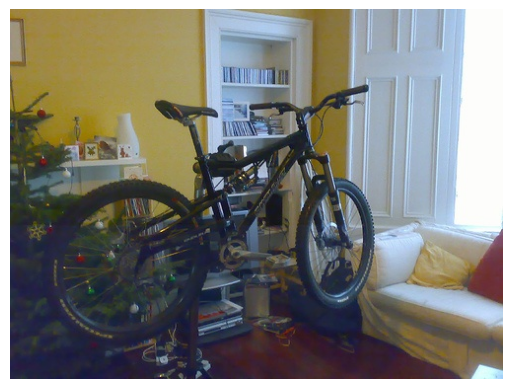

In [8]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[19]))

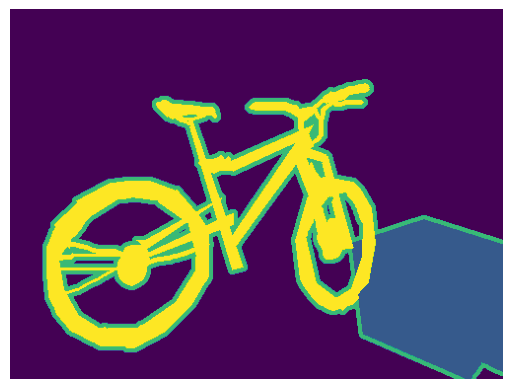

In [9]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[19], color_mode="grayscale"))
display_target(img)

In [10]:
import numpy as np
import random

img_size = (256, 256)
num_imgs = len(input_img_paths)

# random.Random(1337).shuffle(input_img_paths)
# random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 100
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [11]:
print('input_imgs : ',input_imgs.shape)
print('targets : ',targets.shape)
print('train_input_imgs : ',train_input_imgs.shape)
print('train_targets : ',train_targets.shape)
print('val_input_imgs : ',val_input_imgs.shape)
print('val_targets : ',val_targets.shape)

input_imgs :  (300, 256, 256, 3)
targets :  (300, 256, 256, 1)
train_input_imgs :  (200, 256, 256, 3)
train_targets :  (200, 256, 256, 1)
val_input_imgs :  (100, 256, 256, 3)
val_targets :  (100, 256, 256, 1)


In [29]:
from tensorflow import keras
from tensorflow.keras import layers

def get_unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    # 인코더 부분
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # 중간 부분 (바로 아래에 있는 것은 중간 레이어에 해당하지 않음)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # 디코더 부분
    up5 = layers.Conv2DTranspose(256, 2, strides=(2, 2), padding='same')(conv4)
    up5 = layers.concatenate([up5, conv3], axis=3)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv5)
    up6 = layers.concatenate([up6, conv2], axis=3)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv6)
    up7 = layers.concatenate([up7, conv1], axis=3)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = keras.Model(inputs, outputs)
    return model

model = get_unet_model(img_size=img_size, num_classes=21)
# model.summary()

In [13]:
def bce_with_logits_loss(y_true, y_pred):
    bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = bce_loss(y_true, y_pred)
    return loss

In [30]:
import tensorflow as tf

model.compile(optimizer=Adam(learning_rate=0.001), loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
# loss : "sparse_categorical_crossentropy" , bce_with_logits_loss
# tf.keras.losses.BinaryCrossentropy()

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True,
                                    monitor='val_loss',
                                    mode='min'),
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=8,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50
25/25 [==============================] - 67s 2s/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 2/50
25/25 [==============================] - 9s 356ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3/50
25/25 [==============================] - 9s 356ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00
Epoch 3: early stopping


In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [ ]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)